# Part 0: Import Libraries and Prepare Data for Training 

In [11]:
import sagemaker
sess = sagemaker.Session()

bucket = sess.default_bucket()
prefix = 'sagemaker/arvato-batch'

role = sagemaker.get_execution_role()

In [12]:
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.transformer import Transformer
from sagemaker.predictor import csv_serializer, json_deserializer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.sparse
import os
import json

In [13]:
#!mkdir ./data/scaled_raw/
#!aws s3 cp s3://sagemaker-us-east-1-873710589365/sagemaker/arvato/pca_batch/train/mailout_scaled.csv ./data/scaled_raw/

In [14]:
#!mkdir ./data/scaled_raw/
#!aws s3 cp s3://sagemaker-us-east-1-873710589365/sagemaker/arvato/pca_batch/train/mailout_scaled_labeled.csv ./data/scaled_raw/

In [15]:
def load_mailout_scaled(): 
    mailout_scaled = pd.read_csv('./data/scaled_raw/mailout_scaled_true.csv', sep=',')
    mailout_scaled_labeled = pd.read_csv('./data/scaled_raw/mailout_scaled_labeled_true.csv', sep=',')
    mailout_scaled_testing = pd.read_csv('./data/scaled_raw/mailout_scaled_Test_true.csv', sep=',')
    return mailout_scaled, mailout_scaled_labeled, mailout_scaled_testing

In [16]:
mailout_scaled, mailout_scaled_labeled, mailout_scaled_testing = load_mailout_scaled()
# Sanitory check 
mailout_scaled.shape

(42962, 352)

In [17]:
mailout_scaled

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,-0.068673,-0.054556,-0.005092,0.685869,-0.046387,-0.065874,-0.371290,0.600937,0.017429,0.285773,...,-0.766252,1.037710,0.506290,-0.086932,0.174577,0.824885,0.736410,-0.635315,0.247320,0.716231
1,1.566943,0.654954,0.911639,-0.315006,-0.046387,-0.065874,0.261144,-0.306592,0.017429,-0.503298,...,-0.766252,0.138273,0.506290,1.470662,-1.608634,0.824885,-0.200391,0.126513,0.247320,-0.204173
2,-0.068673,0.087346,-0.188439,-0.386497,-0.403260,-0.065874,-1.003724,-0.306592,0.017429,1.074843,...,-0.348470,-1.230925,0.506290,-0.476331,0.174577,-1.212290,0.736410,-1.269273,-1.098278,0.716231
3,-0.068673,-0.338361,-0.371785,-0.100533,-0.046387,-0.065874,0.261144,-0.079710,0.017429,1.074843,...,3.411567,1.037710,0.506290,-0.865730,0.174577,0.824885,0.736410,-0.081258,-1.098278,0.716231
4,-0.068673,0.087346,0.178254,3.402527,-0.046387,-0.065874,-0.371290,2.945386,0.017429,0.285773,...,-0.766252,1.037710,0.506290,-0.086932,0.174577,-1.212290,-0.200391,-0.566058,0.920119,-0.664374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,-0.068673,-1.189774,0.361600,-0.315006,-0.046387,-0.065874,0.261144,-0.230965,0.017429,-1.292369,...,-0.766252,0.138273,0.189298,1.470662,-1.608634,-1.212290,0.736410,1.580912,-0.425479,0.716231
42958,-0.068673,-1.189774,1.094985,-0.315006,-0.046387,-0.065874,0.261144,-0.306592,0.017429,1.074843,...,-0.766252,0.587991,0.506290,1.470662,-1.608634,-1.212290,-0.200391,1.373140,0.920119,0.256029
42959,-0.068673,1.080661,0.361600,-0.243515,-0.046387,-0.065874,0.893577,-0.230965,0.017429,-1.292369,...,-0.766252,-0.761165,0.506290,1.470662,-1.608634,-1.212290,0.736410,1.442398,-0.425479,-0.204173
42960,-0.068673,1.364465,0.911639,-0.172024,-0.046387,-0.065874,0.893577,-0.230965,0.017429,-0.503298,...,0.487094,-0.761165,0.506290,-0.476331,0.174577,0.824885,0.736410,0.957598,1.592918,-0.664374


The column "RESPONSE" was addded in the labeled dataset to prepare for the supervised training.

In [18]:
# Sanitory check 
mailout_scaled_labeled.shape

(42962, 353)

In [19]:
mailout_scaled_labeled

,RESPONSE,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,0,-0.068673,-0.054556,-0.005092,0.685869,-0.046387,-0.065874,-0.371290,0.600937,0.017429,...,-0.766252,1.037710,0.506290,-0.086932,0.174577,0.824885,0.736410,-0.635315,0.247320,0.716231
1,0,1.566943,0.654954,0.911639,-0.315006,-0.046387,-0.065874,0.261144,-0.306592,0.017429,...,-0.766252,0.138273,0.506290,1.470662,-1.608634,0.824885,-0.200391,0.126513,0.247320,-0.204173
2,0,-0.068673,0.087346,-0.188439,-0.386497,-0.403260,-0.065874,-1.003724,-0.306592,0.017429,...,-0.348470,-1.230925,0.506290,-0.476331,0.174577,-1.212290,0.736410,-1.269273,-1.098278,0.716231
3,0,-0.068673,-0.338361,-0.371785,-0.100533,-0.046387,-0.065874,0.261144,-0.079710,0.017429,...,3.411567,1.037710,0.506290,-0.865730,0.174577,0.824885,0.736410,-0.081258,-1.098278,0.716231
4,0,-0.068673,0.087346,0.178254,3.402527,-0.046387,-0.065874,-0.371290,2.945386,0.017429,...,-0.766252,1.037710,0.506290,-0.086932,0.174577,-1.212290,-0.200391,-0.566058,0.920119,-0.664374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,0,-0.068673,-1.189774,0.361600,-0.315006,-0.046387,-0.065874,0.261144,-0.230965,0.017429,...,-0.766252,0.138273,0.189298,1.470662,-1.608634,-1.212290,0.736410,1.580912,-0.425479,0.716231
42958,0,-0.068673,-1.189774,1.094985,-0.315006,-0.046387,-0.065874,0.261144,-0.306592,0.017429,...,-0.766252,0.587991,0.506290,1.470662,-1.608634,-1.212290,-0.200391,1.373140,0.920119,0.256029
42959,0,-0.068673,1.080661,0.361600,-0.243515,-0.046387,-0.065874,0.893577,-0.230965,0.017429,...,-0.766252,-0.761165,0.506290,1.470662,-1.608634,-1.212290,0.736410,1.442398,-0.425479,-0.204173
42960,0,-0.068673,1.364465,0.911639,-0.172024,-0.046387,-0.065874,0.893577,-0.230965,0.017429,...,0.487094,-0.761165,0.506290,-0.476331,0.174577,0.824885,0.736410,0.957598,1.592918,-0.664374


The header in the dataset was removed and the new files were saved locally for the use in SageMaker training

In [20]:
scaled_noheader_dir = 'data/scaled_noheader'

if not os.path.exists(scaled_noheader_dir):
    os.makedirs(scaled_noheader_dir)

mailout_scaled.to_csv('./data/scaled_noheader/mailout_scaled_noheader.csv', header=False, index=False)

In [21]:
scaled_noheader_dir = 'data/scaled_noheader'

if not os.path.exists(scaled_noheader_dir):
    os.makedirs(scaled_noheader_dir)

mailout_scaled_labeled.to_csv('./data/scaled_noheader/mailout_scaled_labeled_noheader.csv', header=False, index=False)

In [22]:
def load_mailout_scaled_labeled_noheader(): 
    mailout = pd.read_csv('./data/scaled_noheader/mailout_scaled_labeled_noheader.csv', sep=',')
    #customers = pd.read_csv('./data/scaled_raw/Customers_scaled.csv', sep=',')
    return mailout

In [23]:
mailout_scaled_labeled_noheader = load_mailout_scaled_labeled_noheader()
# Sanitory check 
mailout_scaled_labeled_noheader.shape

(42961, 353)

In [24]:
mailout_scaled_labeled_noheader

,0,-0.06867340422592477,-0.05455649368400285,-0.005092381818383857,0.6858685919899635,-0.046386930267024964,-0.0658739469488096,-0.3712902416438865,0.6009368389163244,0.0174292651128216,...,-0.7662521064334537,1.0377097796967432,0.5062896589738979,-0.08693234837592517,0.17457723286172214,0.8248848117595067,0.736410039971855,-0.6353150549789552,0.2473197904827699,0.7162311620996881
0,0,1.566943,0.654954,0.911639,-0.315006,-0.046387,-0.065874,0.261144,-0.306592,0.017429,...,-0.766252,0.138273,0.506290,1.470662,-1.608634,0.824885,-0.200391,0.126513,0.247320,-0.204173
1,0,-0.068673,0.087346,-0.188439,-0.386497,-0.403260,-0.065874,-1.003724,-0.306592,0.017429,...,-0.348470,-1.230925,0.506290,-0.476331,0.174577,-1.212290,0.736410,-1.269273,-1.098278,0.716231
2,0,-0.068673,-0.338361,-0.371785,-0.100533,-0.046387,-0.065874,0.261144,-0.079710,0.017429,...,3.411567,1.037710,0.506290,-0.865730,0.174577,0.824885,0.736410,-0.081258,-1.098278,0.716231
3,0,-0.068673,0.087346,0.178254,3.402527,-0.046387,-0.065874,-0.371290,2.945386,0.017429,...,-0.766252,1.037710,0.506290,-0.086932,0.174577,-1.212290,-0.200391,-0.566058,0.920119,-0.664374
4,0,-0.068673,0.513052,0.728293,0.828851,-0.046387,-0.065874,-0.371290,0.449682,0.017429,...,-0.766252,1.037710,0.506290,-0.476331,0.174577,0.824885,-0.200391,-0.773829,0.920119,-0.664374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42956,0,-0.068673,-1.189774,0.361600,-0.315006,-0.046387,-0.065874,0.261144,-0.230965,0.017429,...,-0.766252,0.138273,0.189298,1.470662,-1.608634,-1.212290,0.736410,1.580912,-0.425479,0.716231
42957,0,-0.068673,-1.189774,1.094985,-0.315006,-0.046387,-0.065874,0.261144,-0.306592,0.017429,...,-0.766252,0.587991,0.506290,1.470662,-1.608634,-1.212290,-0.200391,1.373140,0.920119,0.256029
42958,0,-0.068673,1.080661,0.361600,-0.243515,-0.046387,-0.065874,0.893577,-0.230965,0.017429,...,-0.766252,-0.761165,0.506290,1.470662,-1.608634,-1.212290,0.736410,1.442398,-0.425479,-0.204173
42959,0,-0.068673,1.364465,0.911639,-0.172024,-0.046387,-0.065874,0.893577,-0.230965,0.017429,...,0.487094,-0.761165,0.506290,-0.476331,0.174577,0.824885,0.736410,0.957598,1.592918,-0.664374


# Part 1: XGBoost Training 

## Load scaled data into S3 

The local data file ready to use will be uploaded to S3.   

In [25]:
mailout_scaled_labeled_noheader_s3 = sess.upload_data('./data/scaled_noheader/mailout_scaled_labeled_noheader.csv', 
                            bucket=bucket, 
                            key_prefix='{}/pca_batch/train/noheader'.format(prefix))

We'll create an input which can be passed to our SageMaker training estimator.

In [26]:
mailout_input = sagemaker.s3_input(mailout_scaled_labeled_noheader_s3, content_type='text/csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [27]:
list(mailout_scaled.columns)

['AKT_DAT_KL',
 'ALTER_HH',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP',
 'D19_KON

Mailout dataset will be split into training, validation, and test sets. This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

The splitted dataset will be saved as the local files and then be uploaded to S3. 

In [28]:
train_data, validation_data, test_data = np.split(mailout_scaled_labeled.sample(frac=1, random_state=1729), [int(0.7 * len(mailout_scaled)), int(0.9 * len(mailout_scaled))])
train_data.to_csv('./data/scaled_noheader/mailout_labeled_train.csv', header=False, index=False)
validation_data.to_csv('./data/scaled_noheader/mailout_labeled_validation.csv', header=False, index=False)
test_data.to_csv('./data/scaled_noheader/mailout_labeled_test.csv', header=False, index=False)

In [29]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/mailout_labeled_train.csv')).upload_file('./data/scaled_noheader/mailout_labeled_train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/mailout_labeled_validation.csv')).upload_file('./data/scaled_noheader/mailout_labeled_validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/mailout_labeled_test.csv')).upload_file('./data/scaled_noheader/mailout_labeled_test.csv')


## Perform XGBoost training

Now that we've prepared our dataset, let's attempt to model this problem using gradient boosted trees. Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint. XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format. We'll stick with CSV for this training. The dataset has already been prepared and ready to use: 

- Has the predictor variable in the first column
- Not have a header row

Let's proceed with the training. First we'll need to specify the locations of the XGBoost algorithm containers.

In [30]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


We'll create inputs for training, validation, and testing, separately. They can be passed to our SageMaker training estimator.

Because we're training with the CSV file format, we'll create s3_inputs that our training function can use as a pointer to the files in S3.

In [31]:
s3_input_mailout_train = sagemaker.s3_input(s3_data='s3://{}/{}/train/mailout_labeled_train.csv'.format(bucket, prefix), content_type='csv')
s3_input_mailout_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/mailout_labeled_validation.csv'.format(bucket, prefix), content_type='csv')
s3_input_mailout_test = sagemaker.s3_input(s3_data='s3://{}/{}/test/mailout_labeled_test.csv'.format(bucket, prefix), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


A few parameters will be specified like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters as follows:

- `max_depth`: controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample`: controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round`: controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta`: controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma`: controls how aggressively trees are grown.  Larger values lead to more conservative models.


In [32]:
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.9xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_mailout_train, 'validation': s3_input_mailout_validation}) 

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-11-05 03:01:07 Starting - Starting the training job...
2020-11-05 03:01:11 Starting - Launching requested ML instances.........
2020-11-05 03:02:42 Starting - Preparing the instances for training...
2020-11-05 03:03:38 Downloading - Downloading input data
2020-11-05 03:03:38 Training - Downloading the training image...
2020-11-05 03:04:03 Uploading - Uploading generated training modelArguments: train
[2020-11-05:03:03:57:INFO] Running standalone xgboost training.
[2020-11-05:03:03:57:INFO] File size need to be processed in the node: 254.41mb. Available memory size in the node: 62068.11mb
[2020-11-05:03:03:57:INFO] Determined delimiter of CSV input is ','
[03:03:57] S3DistributionType set as FullyReplicated
[03:03:58] 30073x352 matrix with 10585696 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-11-05:03:03:58:INFO] Determined delimiter of CSV input is ','
[03:03:58] S3DistributionType set as FullyReplicated
[03:03:58] 8592x352 matrix with 3


2020-11-05 03:04:30 Completed - Training job completed
Training seconds: 69
Billable seconds: 69


## Compile the trained model

[Amazon SageMaker Neo](https://aws.amazon.com/sagemaker/neo/) optimizes models to run up to twice as fast, with no loss in accuracy. 
When calling `compile_model()` function, we specify the target instance family (m4) as well as the S3 bucket to which the compiled model would be stored.

In [33]:
compiled_model = xgb

if xgb.create_model().check_neo_region(boto3.Session().region_name) is False:
    print('Neo is not currently supported in', boto3.Session().region_name)
else:
    output_path = '/'.join(xgb.output_path.split('/')[:-1])
    compiled_model = xgb.compile_model(target_instance_family='ml_m4', 
                                       input_shape={'data': [1, 352]},
                                       role=role,
                                       framework='xgboost',
                                       framework_version='0.7',
                                       output_path=output_path)
    compiled_model.name = 'deployed-xgboost-mailout'
    compiled_model.image = get_image_uri(sess.boto_region_name, 'xgboost-neo', repo_version='latest')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


?...!

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


## Host as an endpoint

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [34]:
xgb_predictor = compiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

Using already existing model: deployed-xgboost-mailoutml-m4


-----------------!

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request. But first, we'll need to setup serializers and deserializers for passing our test_data NumPy arrays to the model behind the endpoint.

# Part 2: XGBoost Model Validation

In [35]:
from sagemaker.predictor import csv_serializer

In [36]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [37]:
def load_mailout_scaled_labeled_test(): 
    mailout = pd.read_csv('./data/scaled_noheader/mailout_labeled_test.csv', sep=',')
    #customers = pd.read_csv('./data/scaled_raw/Customers_scaled.csv', sep=',')
    return mailout

In [38]:
mailout_labeled_test = load_mailout_scaled_labeled_test()

In [39]:
mailout_labeled_test

,0,-0.06867340422592477,-1.189773559363364,-1.4718625114290742,0.042449408325570384,-0.046386930267024964,-0.0658739469488096,2.158444934068373,-0.0040824223817691645,0.0174292651128216,...,-0.7662521064334537,-0.3114459967755301,0.5062896589738979,-0.4763310039718544,0.17457723286172214,0.8248848117595067,-0.20039110112937786,1.02685501286451,-1.0982779717751916,0.25602930386256456
0,0,-1.124315,-1.393282,-1.429949,-0.420433,-0.403260,-0.838387,-1.404547,-0.418073,-0.589463,...,-0.580476,-1.230925,-2.172726,-1.470068,0.174577,-1.212290,-1.137192,-1.269273,-0.981057,-1.699991
1,0,-0.068673,0.087346,0.178254,0.185431,-0.046387,-0.065874,-0.371290,0.071545,0.017429,...,-0.766252,1.037710,-0.444685,-0.476331,0.174577,-1.212290,0.736410,-0.635315,0.247320,0.716231
2,0,-1.124315,-1.393282,-1.429949,-0.420433,-0.403260,-0.838387,-1.404547,-0.418073,-0.589463,...,-0.580476,-1.230925,-2.172726,-1.470068,0.174577,-1.212290,-0.200391,-1.269273,-0.981057,-1.699991
3,0,-0.068673,0.654954,0.911639,-0.315006,-0.046387,2.498510,0.261144,-0.306592,0.017429,...,1.740439,-1.210883,0.506290,-0.865730,-1.608634,-1.212290,-0.200391,0.749827,-0.425479,0.716231
4,0,-1.124315,-1.393282,-1.429949,-0.420433,-0.403260,-0.838387,-1.404547,-0.418073,-0.589463,...,-0.580476,-1.230925,-2.172726,-1.470068,0.174577,-1.212290,-2.073993,1.026855,-0.981057,-1.699991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4291,0,-0.068673,-1.189774,-1.471863,0.042449,-0.046387,-0.065874,-0.371290,0.071545,0.017429,...,-0.348470,1.037710,0.506290,-0.086932,2.849394,-1.212290,0.736410,-0.773829,0.920119,0.256029
4292,0,-0.068673,1.364465,1.645024,-0.172024,-0.046387,-0.065874,1.526011,-0.230965,0.017429,...,0.069312,-0.761165,0.506290,0.302466,1.066183,0.824885,-2.073993,1.096112,1.592918,-0.204173
4293,0,-0.068673,1.506367,-0.005092,-0.243515,-0.046387,-0.065874,2.158445,-0.306592,0.017429,...,-0.766252,-0.761165,0.506290,1.470662,-1.608634,0.824885,-2.073993,1.303883,-0.425479,0.256029
4294,0,-0.068673,0.229248,0.361600,-0.315006,-0.046387,-0.065874,0.261144,-0.306592,0.017429,...,-0.766252,1.037710,0.506290,-0.086932,-1.608634,0.824885,0.736410,0.195770,-0.425479,1.176433


Now, a simple function will be created to:

- Loop over our test dataset
- Split it into mini-batches of rows
- Convert those mini-batchs to CSV string payloads
- Retrieve mini-batch predictions by invoking the XGBoost endpoint
- Collect predictions and convert from the CSV output our model provides into a NumPy array

In [40]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(mailout_labeled_test.to_numpy()[:,1:])

Let's start by simply by comparing actual to predicted values. 
In this case, we're simply predicting whether the mailout has response (1) or not (0), which produces a simple confusion matrix.

In [41]:
pd.crosstab(index=mailout_labeled_test.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,4246,1
1,49,0


Of the 4297 reponse, we've correctly predicted 4246 of them (true positives). 
And we incorrectly predicted 1 that would respond but then ended up not doing so (false positives). 
There are only 1 that ended up respond, that we predicted would not (false negatives).

An important point here is that because of the np.round() function above we are using a simple threshold (or cutoff) of 0.5. Our predictions from xgboost come out as continuous values between 0 and 1 and we force them into the binary classes that we began with. However, because most of our predictions are below 0.5 as shown below, we should consider adjusting this cutoff.  

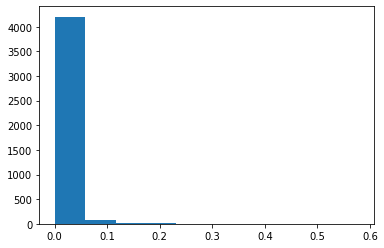

In [42]:
plt.hist(predictions)
plt.show()

Again, since the continuous valued predictions coming from our model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.3 that adjusting the cutoff.

In [43]:
pd.crosstab(index=mailout_labeled_test.iloc[:, 0], columns=np.where(predictions > 0.3, 1, 0))

col_0,0,1
0,,
0,4245,2
1,49,0


# Part 3: Kaggle Competition

Now we are ready to use our trained and validated XGBoost model to predict the response from our mailout test dataset

In [44]:
mailout_scaled_testing

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Temp,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_FAMILY
0,1.000000,7.000000,6.000000,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,...,3.000000,6.000000,9.000000,3.000000,3.0,0.0,4.0,20.000000,1.000000,3.000000
1,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,1.000000,21.000000,0.000000,4.000000,...,1.000000,6.000000,9.000000,5.000000,3.0,0.0,4.0,6.000000,3.000000,1.000000
2,9.000000,16.000000,11.000000,2.000000,0.000000,0.000000,4.000000,2.000000,0.000000,4.000000,...,3.000000,2.000000,9.000000,4.000000,3.0,1.0,4.0,40.000000,4.000000,1.000000
3,7.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,...,3.000000,0.955435,9.000000,2.000000,3.0,1.0,4.0,-1.153689,1.000000,3.000000
4,1.000000,21.000000,13.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,3.000000,...,3.000000,3.000000,9.000000,7.000000,4.0,1.0,4.0,37.000000,3.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42828,-0.936226,-1.434149,0.228603,-0.474689,-0.124437,-0.301247,-0.633778,-0.474075,-0.060155,0.844011,...,1.444672,0.955435,0.548627,-0.551978,3.0,1.0,1.0,-1.153689,1.174229,-1.250353
42829,1.000000,10.000000,10.000000,2.000000,0.000000,0.000000,1.000000,2.000000,0.000000,2.000000,...,6.000000,6.000000,9.000000,3.000000,3.0,0.0,4.0,12.000000,3.000000,1.000000
42830,1.000000,16.000000,15.000000,1.000000,0.000000,2.000000,3.000000,1.000000,0.000000,3.000000,...,1.000000,1.000000,9.000000,3.000000,2.0,0.0,3.0,39.000000,2.000000,4.000000
42831,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,4.000000,...,2.000000,6.000000,9.000000,3.000000,3.0,1.0,3.0,9.000000,1.000000,4.000000


In [45]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions_test = predict(mailout_scaled_testing.to_numpy()[:,:])

In [66]:
mailout_test_raw = pd.read_csv('./data/Input/Udacity_MAILOUT_052018_TEST.csv',sep=';')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [69]:
mailout_test_LNR = mailout_test_raw['LNR']

In [70]:
kaggle_XGBoost = pd.DataFrame(index=mailout_test_LNR, data=predictions_test)
kaggle_XGBoost.rename(columns={0: "RESPONSE"}, inplace=True)

In [71]:
kaggle_XGBoost

,RESPONSE
LNR,
1754,0.000912
1770,0.000350
1465,0.116137
1470,0.256555
1478,0.287405
...,...
67615,0.008877
67938,0.000886
67942,0.001714


In [74]:
files_submission_dir = 'data/submissions'

if not os.path.exists(files_submission_dir):
    os.makedirs(files_submission_dir)

kaggle_XGBoost.to_csv('./data/submissions/submission_XGBoost.csv')

## Clean-up

We will remove the hosted endpoint just created and avoid any charges from a stray instance being left on.

In [75]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)